# TF-IDF

## Import Libraries

In [40]:
from pypdf import PdfReader
from docx import Document
import os
import re
import spacy
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA



## Reading Files

In [ ]:
def read_txt(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()

def read_pdf(file_path):
    reader = PdfReader(file_path)
    text = ''
    for page in reader.pages:
        text += page.extract_text() or ''
    return text

def read_docx(file_path):
    doc = Document(file_path)
    return ' '.join([para.text for para in doc.paragraphs])

def read_file(file_path):
    if file_path.endswith('.txt'):
        return read_txt(file_path)
    elif file_path.endswith('.pdf'):
        return read_pdf(file_path)
    elif file_path.endswith('.docx'):
        return read_docx(file_path)
    else:
        raise ValueError("Unsupported file type")


## Preprocessing

In [38]:
nlp = spacy.load('en_core_web_sm')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_punct]
    return ' '.join(tokens)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abhayjitsinghgulati/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Extract Features

In [ ]:
def extract_features(text_data):
    vectorizer = TfidfVectorizer(max_features=500)
    features = vectorizer.fit_transform(text_data)
    return features


In [31]:
def read_and_preprocess(file_path):
    try:
        content = read_file(file_path)
        processed_text = preprocess_text(content)
        print(f"Processed {file_path}")
        print(processed_text)
        return processed_text
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def process_files(file_paths):
    text_data = [read_and_preprocess(path) for path in file_paths if read_and_preprocess(path) is not None]
    return extract_features(text_data)

file_paths = ['test.txt']
features = process_files(file_paths)


Processed test.txt
sport way forward 

Processed test.txt
sport way forward 



## Clustering 

In [ ]:
def cluster_documents(features, num_clusters=None):
    if num_clusters is None:
        num_clusters = min(3, len(features.toarray()))  # Default to 3 or fewer

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(features)
    return labels, kmeans


In [ ]:
def plot_elbow(features):
    wcss = []
    max_clusters = min(len(features.toarray()), 10)  # Limit clusters to number of samples

    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(features)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters + 1), wcss)
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.title('Elbow Method')
    plt.show()


In [ ]:
def visualize_clusters(features, labels):
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(features.toarray())
    
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis', s=50)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Document Clusters')
    plt.colorbar(label='Cluster')
    plt.show()

Processed test.txt
sport way forward 

Processed test.txt
sport way forward 

Processed test2.txt
science awesome science good
Processed test2.txt
science awesome science good
Processed test3.txt
art way forward 

Processed test3.txt
art way forward 



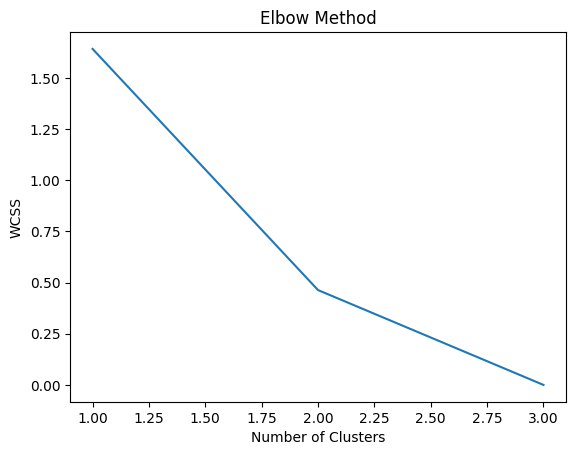

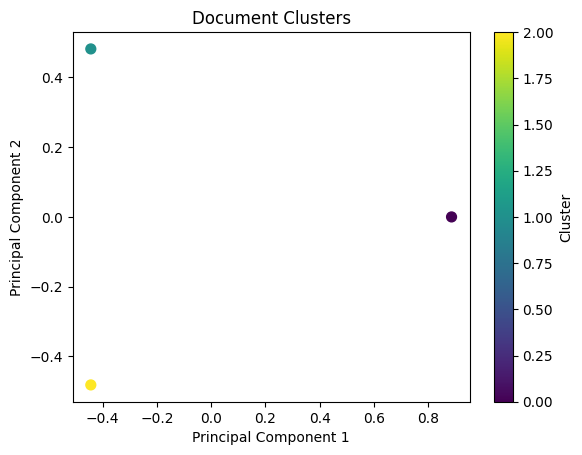

Cluster Labels: [2 0 1]


In [35]:
def main(file_paths):
    # Process files
    features = process_files(file_paths)

    # Plot Elbow Method
    plot_elbow(features)

    # Perform Clustering
    labels, kmeans = cluster_documents(features)

    # Visualize Results
    visualize_clusters(features, labels)

    print("Cluster Labels:", labels)
    
file_paths = ['test.txt', 'test2.txt', 'test3.txt']
main(file_paths)

# LLM Embeddings

Generated embeddings shape: (3, 768)


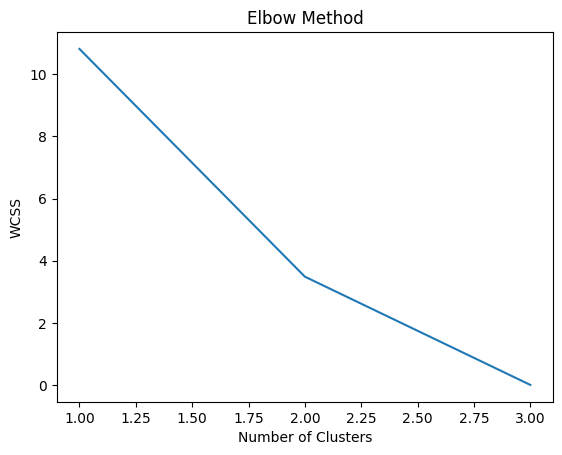

Cluster Labels: [2 0 1]


In [36]:
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def generate_llm_embeddings(texts, model_name='sentence-transformers/all-mpnet-base-v2'):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
            sentence_embedding = outputs.last_hidden_state.mean(dim=1).squeeze()
            embeddings.append(sentence_embedding.numpy())

    return np.array(embeddings)

def plot_elbow(features):
    wcss = []
    max_clusters = min(len(features), 10)
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(features)
        wcss.append(kmeans.inertia_)
    
    plt.plot(range(1, max_clusters + 1), wcss)
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.title('Elbow Method')
    plt.show()

def cluster_documents(features, num_clusters=None):
    if num_clusters is None:
        num_clusters = min(3, len(features))

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(features)
    return labels, kmeans

def main(file_paths):
    texts = [read_file(file_path) for file_path in file_paths]
    embeddings = generate_llm_embeddings(texts)

    print("Generated embeddings shape:", embeddings.shape)

    # Plot Elbow Method
    plot_elbow(embeddings)

    # Perform Clustering
    labels, kmeans = cluster_documents(embeddings)
    print("Cluster Labels:", labels)

file_paths = ['test.txt', 'test2.txt', 'test3.txt']
main(file_paths)
